# app客户流失及客户行为偏好分析

分类信息app，通过数据挖掘分析影响用户流失的关键因素、深入了解用户行为偏好以此做出调整，提升客户留存率，增强客户黏性，并通过随机森林算法预测客户流失，通过特征创造使模型分数提高2个百分点。

**项目内容:**

探索数据分布，缺失情况，针对性的进行缺失值填补，对于缺失较少的重要特征选择随机森林缺失填补法，使用3sigma、箱型图分析等对异常值进行处理，对分类型变量进行编码。
使用方差过滤、F检验过滤掉一部分特征，进行WOE分箱，对每个特征分箱结果进行可视化，分析每个特征分箱情况并以此分析 用户行为偏好，使用各个特征的IV值进一步筛选特征。
训练随机森林模型，模型调参、评估，输出模型，以此模型对用户流失进行预测，以便针对性地挽留用户。训练逻辑回归模型，通过其算法可解释性强的特点(特征系数)来对用户流失关键因素进行阐述。

**使用工具:**

python、pandas、numpy、matplotlib、seaborn、sklearn库

# 1 项目背景

## 1.1 项目目的

深入了解用户画像及行为偏好，挖掘出影响用户流失的关键因素，并通过算法预测客户访问的转化结果，从而更好地完善产品设计、提升用户体验！

## 1.2 数据说明

此次数据是携程用户一周的访问数据，为保护客户隐私，已经将数据经过了脱敏，和实际商品的订单量、浏览量、转化率等有一些差距，不影响问题的可解性。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns = pd.read_excel("./file/字段说明.xlsx")
columns

,字段,解释
0,sampleid,样本id
1,label,目标变量
2,d,访问日期
3,arrival,入住日期
4,iforderpv_24h,24小时内是否访问订单填写页
5,decisionhabit_user,决策习惯：以用户为单位观察决策习惯
6,historyvisit_7ordernum,近7天用户历史订单数
7,historyvisit_totalordernum,近1年用户历史订单数
8,hotelcr,当前酒店历史cr
9,ordercanceledprecent,用户一年内取消订单率


## 1.3 模型选择

本次项目主要从三个方面来分析，客户流失、客户转化和客户价值。

- 客户流失
    - 目标变量label表示是否流失，是0-1二分类问题，目的是需要挖掘出关键因素，拟选用逻辑回归做模型训练及预测。

- 客户转化
    - 预测客户转化率，是连续型变量预测问题，拟选择集成数模型——随机森林回归。

- 客户价值
    - 为了更加细致的挖掘客户价值，选择RFM客户价值模型进行分析。

# 2 数据清洗

In [3]:
plt.rcParams["font.family"] = ["Arial Unicode MS"]
plt.rcParams['axes.unicode_minus']=False

## 2.1 导入数据

In [4]:
data = pd.read_table("./file/userlostprob.txt")
data.head()

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,0,24636,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.04,NaN,...,615.0,NaN,0.29,12.880,3.147,NaN,NaN,7,NaN,12
1,1,24637,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.06,NaN,...,513.0,NaN,0.53,17.933,4.913,NaN,NaN,33,NaN,14
2,0,24641,2016-05-18,2016-05-19,0,NaN,NaN,NaN,1.05,NaN,...,382.0,NaN,0.60,3.993,0.760,NaN,NaN,10,NaN,19
3,0,24642,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.01,NaN,...,203.0,NaN,0.18,3.220,0.660,NaN,NaN,8,NaN,16
4,1,24644,2016-05-18,2016-05-19,0,NaN,NaN,NaN,1.00,NaN,...,84.0,NaN,NaN,0.013,NaN,NaN,NaN,1,NaN,21


## 2.2 数据探索性分析

In [5]:
data.shape

(689945, 51)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689945 entries, 0 to 689944
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   label                             689945 non-null  int64  
 1   sampleid                          689945 non-null  int64  
 2   d                                 689945 non-null  object 
 3   arrival                           689945 non-null  object 
 4   iforderpv_24h                     689945 non-null  int64  
 5   decisionhabit_user                385450 non-null  float64
 6   historyvisit_7ordernum            82915 non-null   float64
 7   historyvisit_totalordernum        386525 non-null  float64
 8   hotelcr                           689148 non-null  float64
 9   ordercanceledprecent              447831 non-null  float64
 10  landhalfhours                     661312 non-null  float64
 11  ordercanncelednum                 447831 non-null  f

### 重复值

In [7]:
data.drop_duplicates(inplace=True)
data.shape

(689945, 51)

### 缺失值

In [8]:
null_ = data.isna().mean().reset_index().sort_values(by=0)
null_1 = null_.rename(columns = {"index":"特征", 0:"缺失比"}).reset_index(drop=True)

In [9]:
null_1

,特征,缺失比
0,label,0.000000
1,sid,0.000000
2,iforderpv_24h,0.000000
3,h,0.000000
4,d,0.000000
5,sampleid,0.000000
6,arrival,0.000000
7,hotelcr,0.001155
8,hoteluv,0.001155
9,lowestprice,0.002919


Text(0, 0.5, '特征变量')

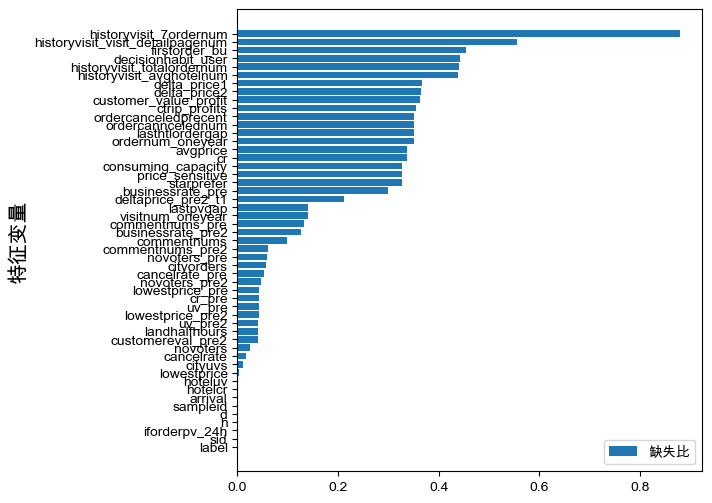

In [10]:
plt.figure(figsize=(6, 6))
plt.barh(null_1.特征, null_1.缺失比, label="缺失比")
plt.legend(loc=4)
plt.ylabel("特征变量", fontsize=15)

In [11]:
null_.rename(columns={"index":"特征", 0:"缺失比"}).set_index("特征")

,缺失比
特征,
label,0.000000
sid,0.000000
iforderpv_24h,0.000000
h,0.000000
d,0.000000
sampleid,0.000000
arrival,0.000000
hotelcr,0.001155
hoteluv,0.001155


<AxesSubplot: >

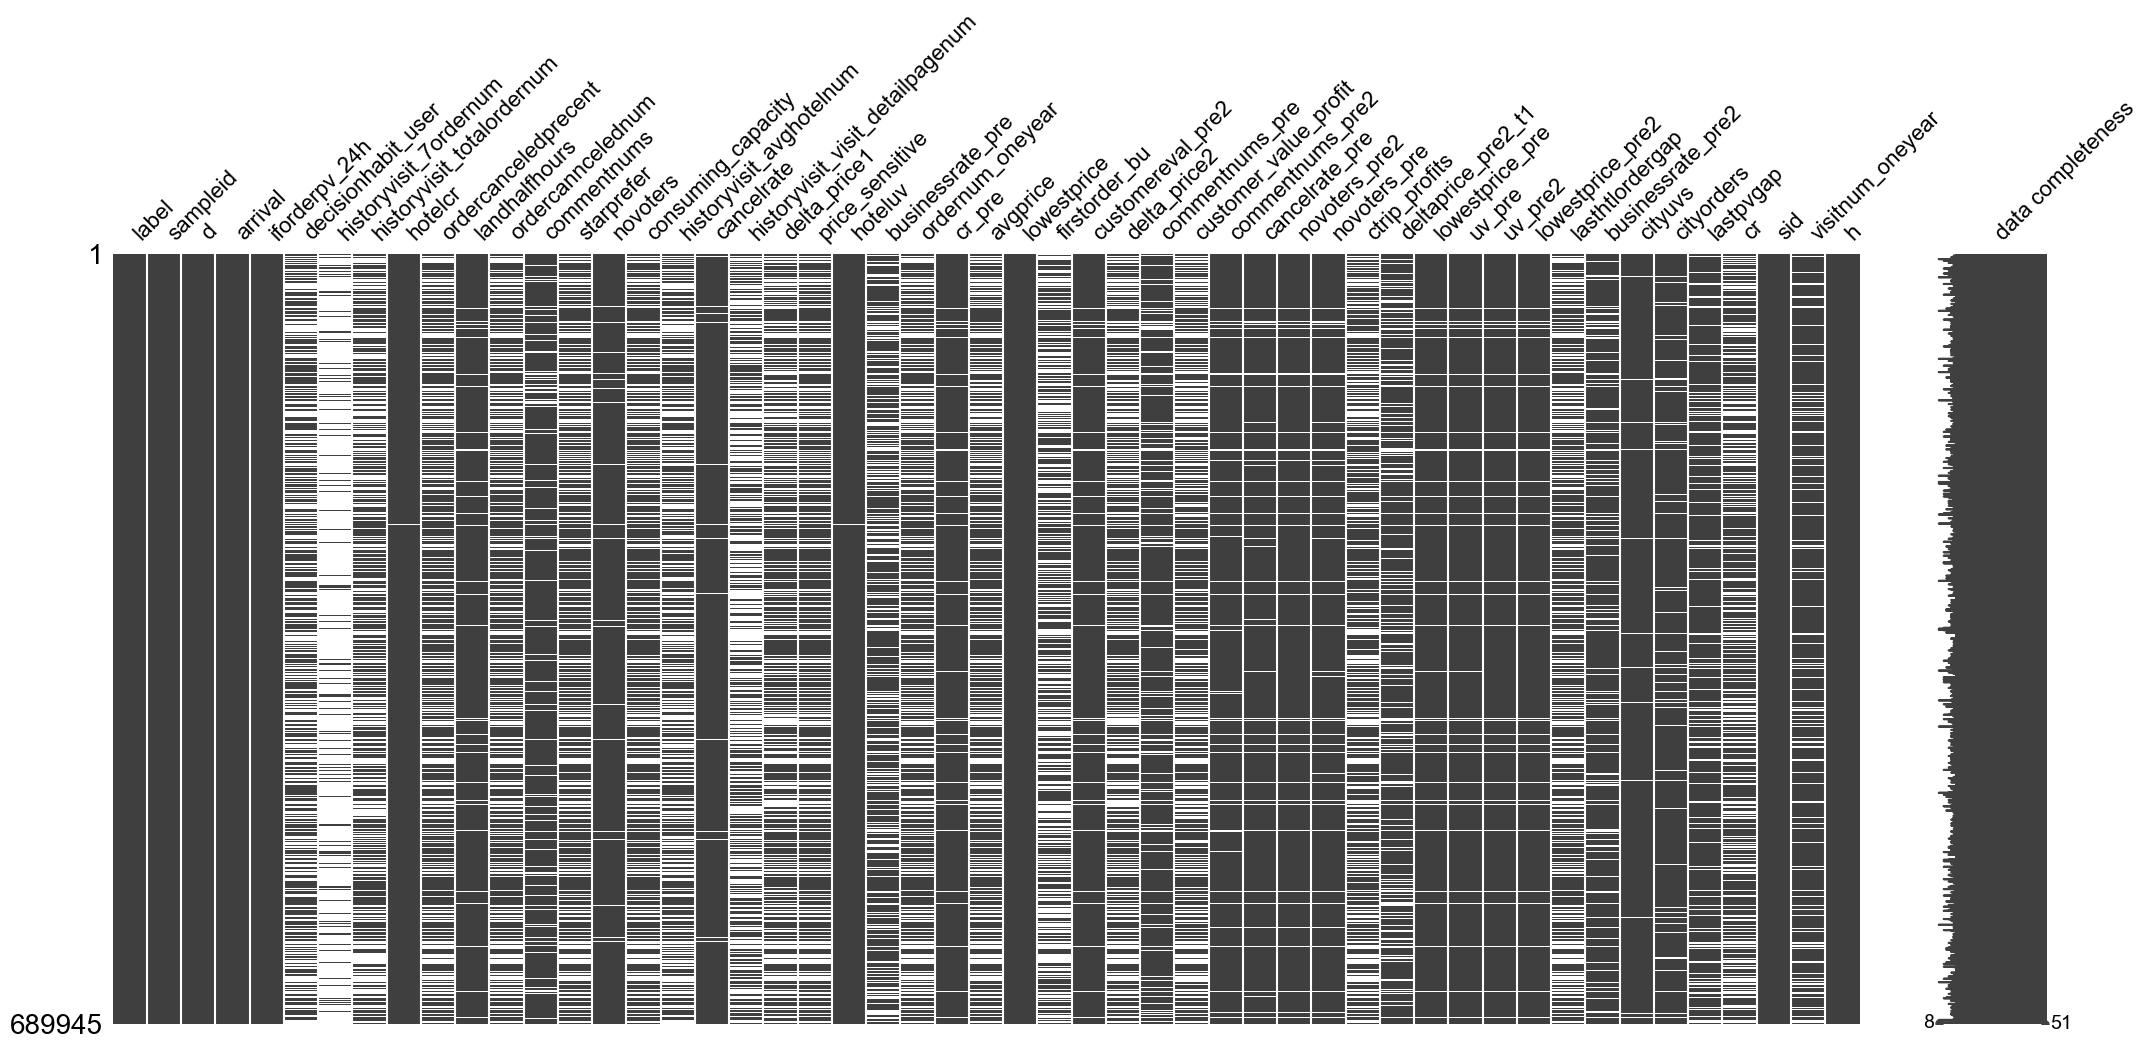

In [12]:
# 可视化缺失值
import missingno as msno
msno.matrix(data, labels=True)

In [13]:
# 删除缺失比例最高的列
data = data.drop(columns=["historyvisit_7ordernum"])

### 异常值

In [14]:
data.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99], include="all").T

,count,unique,top,freq,mean,std,min,1%,25%,50%,75%,99%,max
label,689945.0,NaN,NaN,NaN,0.274452,0.446238,0.0,0.0,0.0,0.0,1.0,1.0,1.0
sampleid,689945.0,NaN,NaN,NaN,628540.209625,414681.498697,24636.0,36205.88,312320.0,599637.0,887460.0,2226892.56,2238426.0
d,689945,7,2016-05-20,111985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival,689945,37,2016-05-20,110982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iforderpv_24h,689945.0,NaN,NaN,NaN,0.193737,0.395226,0.0,0.0,0.0,0.0,0.0,1.0,1.0
decisionhabit_user,385450.0,NaN,NaN,NaN,5.317048,38.524483,0.0,1.0,2.0,3.0,5.0,27.0,3167.0
historyvisit_totalordernum,386525.0,NaN,NaN,NaN,11.710487,17.251429,1.0,1.0,2.0,6.0,14.0,82.0,711.0
hotelcr,689148.0,NaN,NaN,NaN,1.060996,0.045264,1.0,1.0,1.03,1.05,1.09,1.19,3.18
ordercanceledprecent,447831.0,NaN,NaN,NaN,0.342119,0.35421,0.0,0.0,0.0,0.25,0.57,1.0,1.0
landhalfhours,661312.0,NaN,NaN,NaN,6.086366,12.413225,0.0,0.0,0.0,0.0,4.0,48.0,49.0


<AxesSubplot: xlabel='lasthtlordergap'>

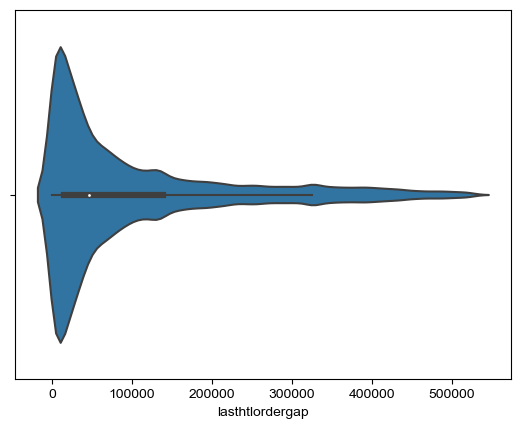

In [15]:
# 箱线图
import seaborn as sns

sns.violinplot(x=data['lasthtlordergap'])

#### 定义盖帽法处理异常值

In [16]:
data.loc[:, ['lowestprice','lowestprice_pre']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,10%,25%,50%,75%,99%,max
lowestprice,687931.0,318.806242,575.782415,-3.0,80.0,116.0,200.0,380.0,1823.0,100000.0
lowestprice_pre,659689.0,315.954583,463.723643,1.0,80.0,118.0,208.0,385.0,1750.0,100000.0


In [17]:
def block_lower(x):
    # x是输⼊入的Series对象,替换1%分位数
    q1 = x.quantile(.99)
    out = x.mask(x<q1)
    return out

def block_upper(x):
    # x是输⼊入的Series对象,l替换99%分位数
    qu = x.quantile(.99)
    out = x.mask(x>qu, qu)
    return(out)

In [18]:
# 应用盖帽法
data.loc[:, ['lowestprice','lowestprice_pre']] = data.loc[:, ['lowestprice','lowestprice_pre']].apply(block_lower)
data.loc[:, ['lowestprice','lowestprice_pre']] = data.loc[:, ['lowestprice','lowestprice_pre']].apply(block_upper)

In [19]:
data.loc[:, ['lowestprice','lowestprice_pre']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,10%,25%,50%,75%,99%,max
lowestprice,6893.0,3024.240534,1749.986012,1823.0,1889.0,2028.0,2500.0,3200.0,12888.0,12888.0
lowestprice_pre,6674.0,2769.035361,1357.533511,1750.0,1812.0,1925.0,2300.0,2980.0,9880.0,9880.0


# 3 划分测试集和训练集

In [20]:
# 备份数据
data_copy = data.copy()

In [21]:
from sklearn.model_selection import train_test_split

X = data_copy.iloc[:,2:]   # 特征
y = data_copy.label    # 目标值
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

In [22]:
# 特征创造
date_train = X_train.iloc[:, :2]
date_test = X_test.iloc[:, :2]
date_train.reset_index(drop=True)
date_test.reset_index(drop=True)

,d,arrival
0,2016-05-20,2016-05-21
1,2016-05-15,2016-05-15
2,2016-05-15,2016-05-15
3,2016-05-20,2016-05-20
4,2016-05-20,2016-06-07
...,...,...
206979,2016-05-16,2016-05-28
206980,2016-05-15,2016-05-15
206981,2016-05-19,2016-06-09
206982,2016-05-19,2016-05-22


**知识点：object数据类型是dataframe中特殊的数据类型,当某一列出现数字、字符串、特殊字符和时间格式两种及以上时,就会出现object类型,即便把不同类型的拆分开,仍然是object类型.**

In [23]:
col_no = ['sid', 'iforderpv_24h', 'h']    # 没有缺失值的特征
col_clf = ['decisionhabit_user']    # 分类型变量
# 筛选包含负值的列
dfc = pd.DataFrame([{k: False if str(t) == "object" else (data.loc[:, [k]]<0).any().all() for k, t in data.dtypes.to_dict().items()}]).T.reset_index().rename(columns={"index":"column_name", 0:"isnegative"})
col_neg = dfc[dfc["isnegative"]==True].column_name.to_list()
# std>100
col_std = data.columns[data.describe(include="all").T["std"] > 100].to_list()   
col_std.remove("sampleid")
col_std.remove("delta_price1")
col_std.remove("delta_price2")
col_std.remove("lasthtlordergap")

In [24]:
col_35 = null_1[(null_1.缺失比 >= 0.35) & (null_1.缺失比 <= 0.55)].特征.to_list()

In [31]:
cols = X.columns.to_list()
col_norm = list(set(cols)-set(col_clf + col_std + col_neg + col_no +col_35))
col_norm.remove("d")
col_norm.remove("arrival")
col_norm

['customereval_pre2',
 'cancelrate_pre',
 'hotelcr',
 'cr_pre',
 'starprefer',
 'price_sensitive',
 'cityorders',
 'landhalfhours',
 'consuming_capacity',
 'cityuvs',
 'businessrate_pre2',
 'cr',
 'businessrate_pre',
 'historyvisit_visit_detailpagenum']

# 4 缺失值填补

- 分类型变量用 '众数填补' —— col_clf
- 含有负数的特征用 '中值填补' —— col_neg
- std > 100 方差大于100的连续型变量用 '中值填补' —— col_std
- 缺失35%——55%用 '常数 -1 填充' 单独做一类
- 其余变量用 '均值填补' —— col_norm

**知识点：过拟合：算法具有高方差（用比较多的变量x去拟合数据集，但是数据量不足以多去约束这些变量，导致这个算法用到新的样本集中去时，表现效果不好，即泛化能力差）。**

In [40]:
X_train.loc[:, col_clf] = X_train.loc[:, col_clf].fillna(X_train.loc[:, col_clf].mode())
X_train.loc[:, col_neg] = X_train.loc[:, col_neg].fillna(X_train.loc[:, col_neg].median())
X_train.loc[:, col_std] = X_train.loc[:, col_std].fillna(X_train.loc[:, col_std].median())
X_train.loc[:, col_35] = X_train.loc[:, col_35].fillna(-1)
X_train.loc[:, col_norm] = X_train.loc[:, col_norm].fillna(X_train.loc[:, col_norm].mean())

In [42]:
X_test.loc[:,col_clf] = X_test.loc[:, col_clf].fillna(X_test.loc[:, col_clf].mode())
X_test.loc[:, col_neg] = X_test.loc[:, col_neg].fillna(X_test.loc[:, col_neg].median())
X_test.loc[:, col_std] = X_test.loc[:, col_std].fillna(X_test.loc[:, col_std].median())
X_test.loc[:, col_35] = X_test.loc[:, col_35].fillna(-1)
X_test.loc[:, col_norm] = X_test.loc[:, col_norm].fillna(X_test.loc[:, col_norm].mean())

#### 检查缺失值填补情况

In [44]:
X_train.isna().any().sum()

0

In [46]:
X_test.isna().any().sum()

0

# 5 特征选择

In [50]:
y.value_counts()

0    500588
1    189357
Name: label, dtype: int64

In [51]:
500588/189357

2.6436202516938905

In [52]:
y.shape

(689945,)

In [53]:
X.shape

(689945, 48)

In [54]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
iforderpv_24h,482961.0,0.193548,0.395079,0.000,0.000,0.000000,0.000000,1.000
decisionhabit_user,482961.0,2.531420,29.392478,-1.000,-1.000,1.000000,3.000000,2383.000
historyvisit_totalordernum,482961.0,6.128317,14.346261,-1.000,-1.000,1.000000,7.000000,711.000
hotelcr,482961.0,1.061004,0.045234,1.000,1.030,1.050000,1.090000,3.180
ordercanceledprecent,482961.0,-0.129285,0.700904,-1.000,-1.000,0.000000,0.400000,1.000
landhalfhours,482961.0,6.069654,12.138277,0.000,0.000,0.000000,6.069654,49.000
ordercanncelednum,482961.0,100.740681,326.563902,0.000,1.000,2.000000,5.000000,13475.000
commentnums,482961.0,1198.112061,2014.221599,0.000,144.000,513.000000,1466.000000,34189.000
starprefer,482961.0,67.543379,15.739452,0.000,60.000,67.543379,77.100000,100.000
novoters,482961.0,1682.289030,2789.022950,1.000,165.000,691.000000,2129.000000,45455.000


本次选用简单粗暴的方差过滤、F_检验、 以及嵌入法特征选择，利用树模型的特征重要性输出结合模型效果，选择对模型贡献最大的那个几个变量。事实证明，此方法效果明显，最后成功选择出8个特征。